<a href="https://colab.research.google.com/github/sana202186/Use-Case-RTS/blob/main/UseCase_Sana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import difflib
import seaborn as sns
from prophet import Prophet
import plotly.express as px

In [61]:
metrics = pd.read_csv("sample_data/Mesures.csv", encoding="latin-1", sep=";")

In [62]:
tags = pd.read_csv("sample_data/Tags.csv", encoding="latin-1", sep=";")

In [63]:
print("Fichiers chargés")
print("Tags :", tags.shape, " | Metrics :", metrics.shape)

Fichiers chargés
Tags : (107802, 4)  | Metrics : (277586, 17)


In [64]:
# Suppression des espaces dans les noms de colonnes
tags.columns = tags.columns.str.strip()
metrics.columns = metrics.columns.str.strip()

# Suppression des espaces superflus dans les cellules
for df in [tags, metrics]:
    df.replace(r'^\s+|\s+$', '', regex=True, inplace=True)

# Suppression des lignes entièrement vides
tags.dropna(how='all', inplace=True)
metrics.dropna(how='all', inplace=True)

In [65]:
print("Fichiers chargés")
print("Tags :", tags.shape, " | Metrics :", metrics.shape)

Fichiers chargés
Tags : (107802, 4)  | Metrics : (277586, 17)


In [66]:
# Harmonisation des identifiants
tags['Segment ID'] = tags['Segment ID'].astype(str).str.strip()
metrics['Segment ID'] = metrics['Segment ID'].astype(str).str.strip()

# Nettoyage des valeurs numériques et textuelles
# Conversion du taux de nouvelles visites en float
if 'New Visit Rate %' in metrics.columns:
    metrics['New Visit Rate %'] = (
        metrics['New Visit Rate %']
        .astype(str)
        .str.replace('%', '', regex=False)
        .str.replace(',', '.', regex=False)
    )
    metrics['New Visit Rate %'] = pd.to_numeric(metrics['New Visit Rate %'], errors='coerce')

In [67]:
print("Fichiers chargés")
print("Tags :", tags.shape, " | Metrics :", metrics.shape)

Fichiers chargés
Tags : (107802, 4)  | Metrics : (277586, 17)


In [68]:
# Conversion du temps moyen de lecture en secondes
def time_to_seconds(t):
    try:
        h, m, s = map(int, str(t).split(':'))
        return h*3600 + m*60 + s
    except:
        return np.nan

if 'Avg Play Duration' in metrics.columns:
    metrics['Avg Play Duration (s)'] = metrics['Avg Play Duration'].apply(time_to_seconds)
if 'Total Play Duration' in metrics.columns:
    metrics['Total Play Duration (s)'] = df['Total Play Duration'].apply(time_to_seconds)

# Suppression des doublons
tags.drop_duplicates(subset="Segment ID", inplace=True)
metrics.drop_duplicates(subset="Segment ID", inplace=True)

In [69]:
print("Fichiers nettoyés")
print("Tags :", tags.shape, " | Metrics :", metrics.shape)

Fichiers nettoyés
Tags : (80731, 4)  | Metrics : (82546, 19)


In [70]:
#Vérifications avant fusion
common_ids = set(tags['Segment ID']) & set(metrics['Segment ID'])
print(f"\n Vérification des identifiants :")
print(f"- IDs communs : {len(common_ids)}")
print(f"- IDs uniquement dans Mesures : {len(set(metrics['Segment ID']) - common_ids)}")
print(f"- IDs uniquement dans Tags : {len(set(tags['Segment ID']) - common_ids)}")


 Vérification des identifiants :
- IDs communs : 80731
- IDs uniquement dans Mesures : 1815
- IDs uniquement dans Tags : 0


In [71]:
# Fusion
merged = pd.merge(
    metrics,
    tags[['Segment ID', 'Assigned Tags']],
    on='Segment ID',
    how='left'
)

In [72]:
print("Dimensions finales :", merged.shape)

Dimensions finales : (82546, 20)


In [73]:
#  Sauvegarde du fichier propre ===
output_path = "sample_data/Metrics_Tags_Clean.csv"
merged.to_csv(output_path, index=False, encoding="utf-8-sig")
print(f" Fichier nettoyé et fusionné enregistré sous : {output_path}")

# =Aperçu des données ===
#display(merged.head(10))

 Fichier nettoyé et fusionné enregistré sous : sample_data/Metrics_Tags_Clean.csv


In [77]:
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

df = merged.copy()  # travail sur une copie

# Fonction de nettoyage
def clean_tag(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'media_radio|rts_info|la-1ere|media_tv|couleur3|podcasts-originaux', '', text)
    text = text.replace('_', ' ').replace(':', ' ')
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Nettoyer les tags
df['Cleaned'] = df['Assigned Tags'].apply(clean_tag)

# Matrice terme-document
vectorizer = CountVectorizer(stop_words=None)
X = vectorizer.fit_transform(df['Cleaned'])

# LDA : 20 thèmes
lda = LatentDirichletAllocation(n_components=20, random_state=42)
lda.fit(X)

# Récupération des mots
words = vectorizer.get_feature_names_out()

# Affichage des 10 mots principaux par thème
for i, topic in enumerate(lda.components_):
    top_words = [words[j] for j in topic.argsort()[-10:]]  # <-- correction ici
    print(f"Thème {i+1} :", ", ".join(top_words))



Thème 1 : entretiens, espace, religions, humour, consommation, sciences, reportages, tech, culture, info
Thème 2 : sports, 2020, tourisme, institutions, radio, politique, archives, product, q670999, consommation
Thème 3 : info, sciences, option, culture, reportages, documentaires, musique, humour, entretiens, societe
Thème 4 : autres, cantons, societe, thesaurus, bisbale, entretiens, espace, musique, info, culture
Thème 5 : chimie, physique, animaux, plantes, medecine, sante, et, sciences, themes, cqfd
Thème 6 : culture, economie, geneve, berne, reportages, neuchatel, regions, jura, vaud, info
Thème 7 : famille, conso, sante, bien, etre, consommation, themes, en, on, parle
Thème 8 : radio, autres, religions, economie, sports, 2020, decennies, reportages, monde, info
Thème 9 : neuchatel, suisse, archives, musique, entretiens, documentaires, info, tech, reportages, sciences
Thème 10 : geneve, neuchatel, suisse, espace, musique, info, culture, reportages, humour, fiction
Thème 11 : archeo

In [78]:
import re

# 1. Remplir les NaN
merged['Assigned Tags'] = merged['Assigned Tags'].fillna('')

# 2. Split + nettoyage
def clean_tags(tag_string):
    # Séparer par ":" ou ","
    tags = re.split(':|,', tag_string)
    cleaned = []
    for t in tags:
        t = t.strip().lower()
        # Supprimer les préfixes/éléments récurrents
        t = re.sub(r'\b(media_radio|la-1ere|rts_info|podcasts|espace-2|consommation|media|tv|couleur3|valais)\b', '', t)
        t = t.strip('_-: ')
        if t:  # ne garder que les tags non vides
            cleaned.append(t)
    return cleaned

merged['cleaned_tags'] = merged['Assigned Tags'].apply(clean_tags)

# 3. Fonction pour assigner le thème
theme_keywords = {
    'Info': ['info', 'reportages', 'news', 'economie' ,'monde'],
    'Sport': ['sport', 'match', 'football', 'basket', 'tennis', 'rugby', 'athlétisme'],
    'Musique': ['musique', 'concert', 'chanson', 'album', 'pop', 'rock', 'classique'],
    'Société': ['societe', 'entretiens', 'social', 'documentaire social', 'culture'],
    'Humour': ['humour', 'comedy', 'blague', 'sketch', 'stand-up']
}


def assign_theme(tags_list):
    for tag in tags_list:
        for theme, keywords in theme_keywords.items():
            if any(kw in tag for kw in keywords):
                return theme
    return 'Autre'

merged['Theme_Final'] = merged['cleaned_tags'].apply(assign_theme)

# 4. Vérifier le résultat
print(merged['Theme_Final'].value_counts())






Theme_Final
Autre      68403
Info        8320
Musique     3055
Société     1673
Humour       819
Sport        276
Name: count, dtype: int64


In [79]:
theme_metrics = merged.groupby('Theme_Final').agg({
    'Segment ID': 'count',                  # nombre de segments produits
    'Media Views': 'sum',                   # total des vues
    'Visitors': 'sum',                      # nombre de visiteurs uniques
    'Returning Visits': 'sum',              # visites de retour
    'Bounces': 'sum',                        # rebonds
    'Total Play Duration (s)': 'sum',       # engagement total
    'Avg Play Duration (s)': 'mean',         # durée moyenne de visionnage
    'New Visit Rate %': 'mean' # Add mean of New Visit Rate %
}).rename(columns={'Segment ID':'Num_Segments'})

In [80]:
print(df.columns)

Index(['Segment ID', 'Segment', 'Show ID', 'Show', 'Publication Date',
       'App/Site Name', 'Device Class', 'Segment Length', 'Media Views',
       'Avg Play Duration', 'Visitors', 'New Visit Rate %', 'Entries', 'Exits',
       'Returning Visits', 'Bounces', 'Total Play Duration',
       'Avg Play Duration (s)', 'Total Play Duration (s)', 'Assigned Tags',
       'Cleaned'],
      dtype='object')


In [81]:
# Calculer les scores Acquisition, Retention, Engagement ---
theme_metrics['Acquisition_Score'] = theme_metrics['Visitors'] * theme_metrics['New Visit Rate %'] / 100
theme_metrics['Retention_Score'] = theme_metrics['Returning Visits']
theme_metrics['Engagement_Score'] = theme_metrics['Total Play Duration (s)']

In [82]:
# Normalisation pour comparer facilement
for col in ['Acquisition_Score','Retention_Score','Engagement_Score']:
    theme_metrics[col+'_norm'] = theme_metrics[col] / theme_metrics[col].max()

In [83]:
# Priorisation des thèmes pour production ---
theme_metrics['Priority_Score'] = 0.6*theme_metrics['Acquisition_Score_norm'] + 0.4*theme_metrics['Retention_Score_norm']
theme_metrics = theme_metrics.sort_values('Priority_Score', ascending=False)

In [84]:
# Exporter pour Power BI ou rapport ---
theme_metrics.to_csv("Theme_Metrics_Analysis.csv", index=True)

In [85]:
#Exploration des données avec des graphiques python
# Style global
sns.set(style="whitegrid", palette="muted", font_scale=1.1)


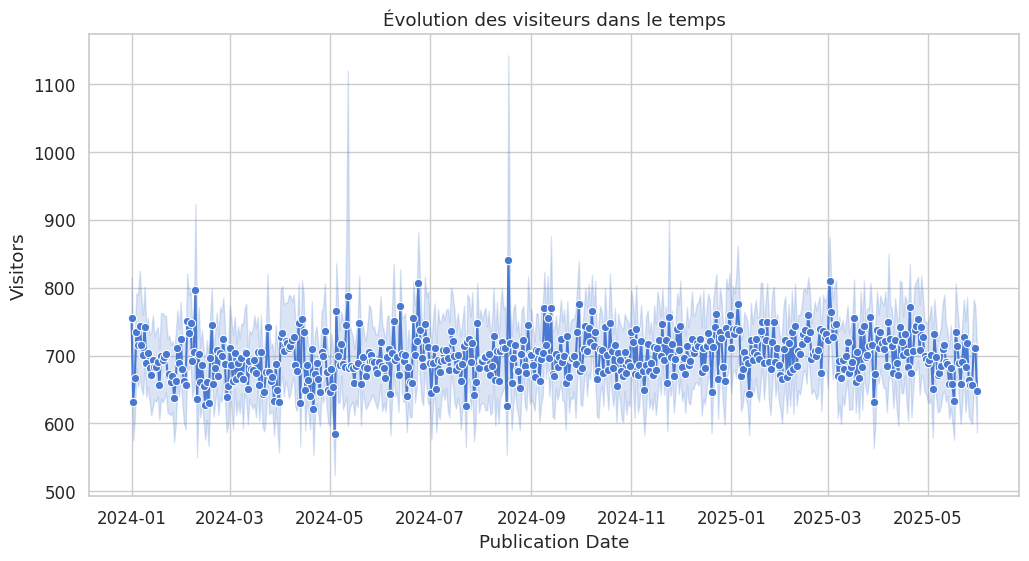

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
df=merged
df['Publication Date'] = pd.to_datetime(df['Publication Date'], dayfirst=True)

plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Publication Date', y='Visitors', marker='o')
plt.title("Évolution des visiteurs dans le temps")
plt.show()



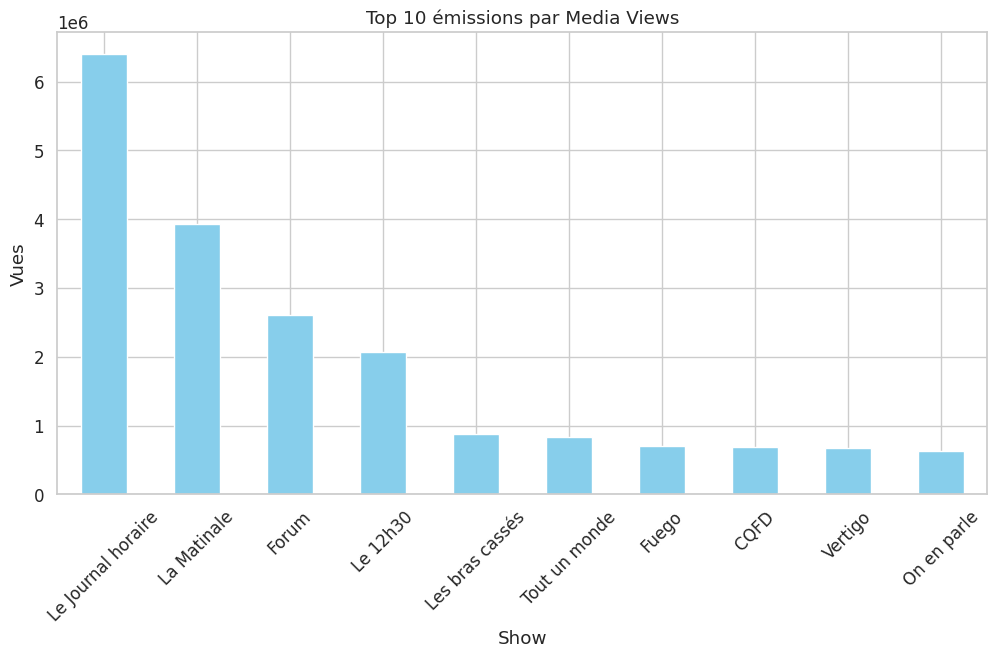

In [88]:
plt.figure(figsize=(12,6))
top_shows = df.groupby('Show')['Media Views'].sum().sort_values(ascending=False).head(10)
top_shows.plot(kind='bar', color='skyblue')
plt.title("Top 10 émissions par Media Views")
plt.ylabel("Vues")
plt.xticks(rotation=45)
plt.show()

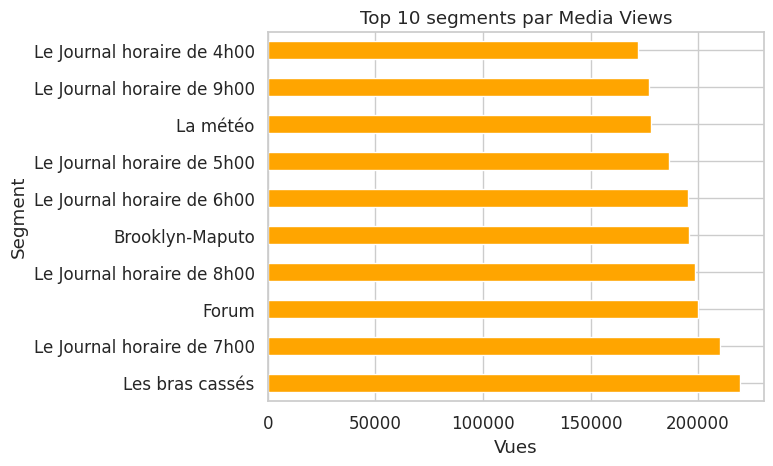

In [91]:
top_segments = df.groupby('Segment')['Media Views'].sum().sort_values(ascending=False).head(10)
top_segments.plot(kind='barh', color='orange')
plt.title("Top 10 segments par Media Views")
plt.xlabel("Vues")
plt.show()